In [1]:
import glob
import pandas as pd
import numpy as np
from itertools import product
import networkx as nx
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt, colors, cm

# 20210222

The goal of this notebook is to address the data normalization problem with files in [../data/all_stab_scores](../data/all_stab_scores). In short, I want to partition stability score CSV files such that each partition has its own Data Resource and schema. The columns in schema should be as "close" to the non-empty columns in the files of the partition as possible. At the same time, we want as few partitions as possible (otherwise, optimal solution would be a single Data Resource for each CSV file).

Continuation of [20210201](./20210201.ipynb) notebook. I'll probably use sklearn k-means instead of sknetwork this time.

### Links

* [Overview of graph clustering methods](https://www.csc2.ncsu.edu/faculty/nfsamato/practical-graph-mining-with-R/slides/pdf/Graph_Cluster_Analysis.pdf)

----

First step is to represent these files as a graph:

In [99]:
primary_keys = ['dataset', 'name', 'chip_name']

In [100]:
all_fps = glob.glob("../data/all_stab_scores/og/*.csv")
all_fps

['../data/all_stab_scores/og/topology_mining_rd2.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/181114_IL_binders_FS.v2.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Inna.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_scrambled_controls_display_vector_2.rd4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_display_vector_2.rd4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd1.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva1_scrambled_controls.v3.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva2.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd3.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/100K_winter19.v3.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd4.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Longxing_scrambled_controls.v3

Get columns (excluding primary keys) in each CSV file, and assign an integer index for convenience:

In [101]:
def get_cols(fp, primary_keys: list = primary_keys) -> list:
    """Get columns in CSV file `fp`, and remove primary keys"""
    all_cols = pd.read_csv(fp).columns.tolist()
    return [c for c in all_cols if c not in primary_keys]
col_dict = {int_idx: get_cols(fp) for int_idx, fp in enumerate(all_fps)}

/Users/TASethanho/anaconda3/envs/frictionless/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [102]:
def get_fdict_from_cdict(cdict):
    """Converts dictionary like `col_dict` to dictionary keyed by
    column, where value is the set of files that contain that column.
    This dict's keys are then assigned integer values for convenience.
    The integer <> column name mapping is returned as `cmap`, and the
    dictionary of files keyed by the columns they contain is returned
    as `fdict`.
    """
    # generate dictionary keyed by column name
    fdict = dict()
    for file, cols in col_dict.items():
        for cname in cols:
            if cname in fdict:
                fdict[cname].add(file)
            else:
                fdict[cname] = set([file])
    
    # convert keys to integers and create mapping
    cmap = dict()
    keys = list(fdict.keys())
    for i, cname in enumerate(keys):
        fdict[i] = fdict[cname]
        cmap[i] = cname
        del fdict[cname]
    return fdict, cmap

fdict, cmap = get_fdict_from_cdict(col_dict)
assert len(cmap) == len(fdict)

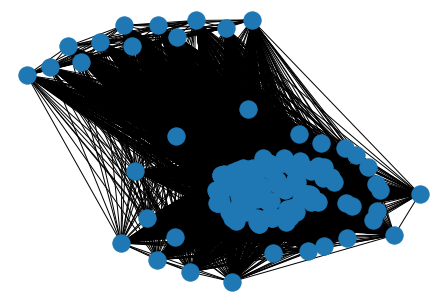

In [103]:
def get_graph_from_fdict(fdict, cmap=dict()):
    """Returns a NetworkX graph from an `fdict`, where
    nodes are columns. The weight of each edge is the
    number of files that contain both columns (nodes).
    """
    g = nx.Graph()
    for k1, k2 in product(*[list(fdict.keys())] * 2):
        if k1 == k2:
            continue

        # determine which files are shared
        f1 = set(fdict[k1])
        f2 = set(fdict[k2])
        shared = f1.intersection(f2)

        # add graph edge
        props = {
            'shared_files': shared,
            'weight': len(shared)
        }
        g.add_edge(k1, k2, **props)
        
        # add node attr for convenience
        g.nodes[k1]['column_name'] = cmap.get(k1, None)
        g.nodes[k2]['column_name'] = cmap.get(k2, None)
    return g

g = get_graph_from_fdict(fdict, cmap=cmap)
nx.draw(g, with_labels=False)

Set up a weighted adjacency matrix: iterate over every pair of files `(n1, n2)`:

In [104]:
def get_adj_from_fdict(fdict):
    """Return up 2-D adjacency matrix given an `fdict`. Values
    are the same as the edge `weight` attribute in
    `get_graph_from_fdict`.
    """
    adj = np.zeros(shape=[len(fdict), len(fdict)], dtype=int)
    for k1, k2 in product(*[list(fdict.keys())] * 2):
        adj[k1, k2] = len(fdict[k1].intersection(fdict[k2]))
    return adj

adj = get_adj_from_fdict(fdict)
adj

array([[12, 12, 12, ...,  1,  1,  1],
       [12, 12, 12, ...,  1,  1,  1],
       [12, 12, 12, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  0,  0],
       [ 1,  1,  1, ...,  0,  1,  1],
       [ 1,  1,  1, ...,  0,  1,  1]])

Now, we apply KMeans clustering to get groupings of columns:

In [105]:
k = 3
km = KMeans(k).fit(adj)
labs =  km.labels_

Visualize the clusters (credit to this [excellent tutorial](https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/)):

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


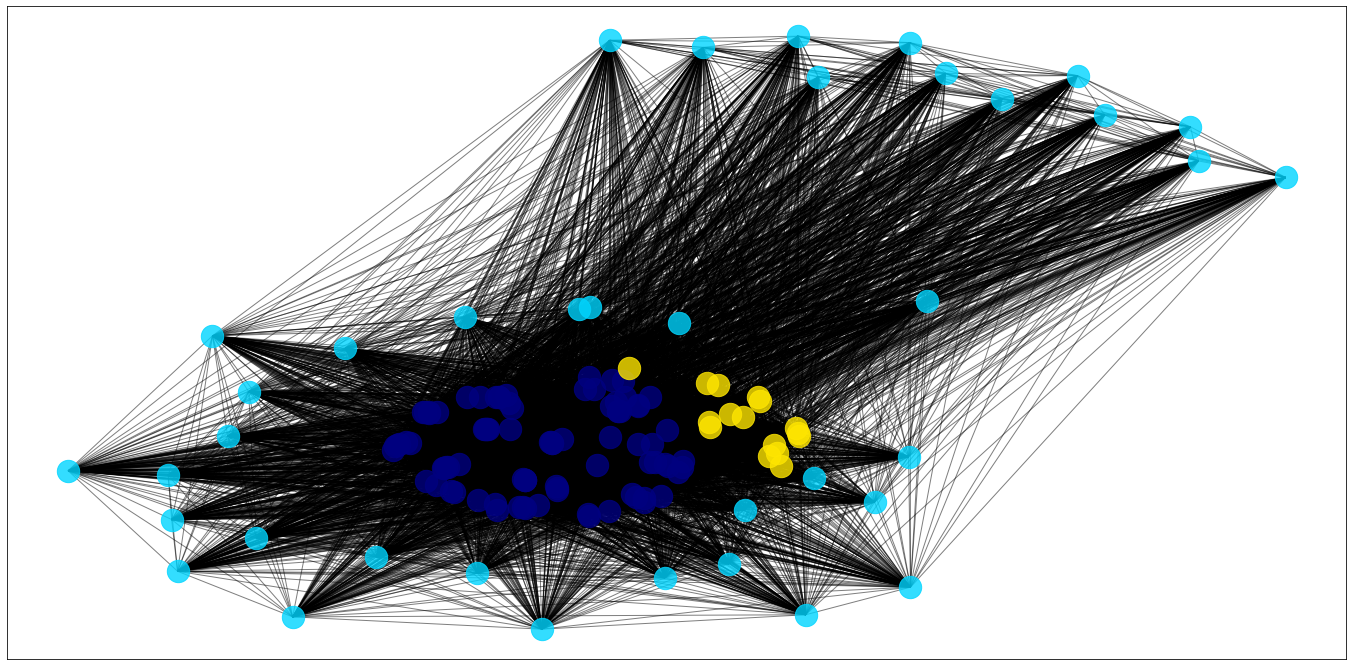

In [106]:
def draw_communities(G, membership, pos):
    """Credit to https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/
    """ 
    fig, ax = plt.subplots(figsize=(24,12))
    
    # Convert membership list to a dict where key=club, value=list of students in club
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)
    
    # Normalize number of clubs for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))
    
    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(club)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

draw_communities(g, labs, nx.spring_layout(g))

`k = 3` visually generates "good" partitions. Let's load the labels into NetworkX for convenience:

In [107]:
for i, lab in enumerate(labs):
    g.nodes[i]['label'] = lab

Finally, let's actually get the groups of column names:

In [108]:
col_groups = {key: set() for key in range(k)}
for i, n in g.nodes.items():
    # print(n)
    col_groups[n['label']].add(n['column_name'])
col_groups

{0: {'counts0_c',
  'counts0_t',
  'counts1_c',
  'counts1_t',
  'counts2_c',
  'counts2_t',
  'counts3_c',
  'counts3_t',
  'counts4_c',
  'counts4_t',
  'counts5_c',
  'counts5_t',
  'counts6_c',
  'counts6_t',
  'delta_llh1_c',
  'delta_llh1_t',
  'delta_llh2_c',
  'delta_llh2_t',
  'delta_llh3_c',
  'delta_llh3_t',
  'delta_llh4_c',
  'delta_llh4_t',
  'delta_llh5_c',
  'delta_llh5_t',
  'delta_llh6_c',
  'delta_llh6_t',
  'downsamp_counts1_c',
  'downsamp_counts1_t',
  'downsamp_counts2_c',
  'downsamp_counts2_t',
  'downsamp_counts3_c',
  'downsamp_counts3_t',
  'downsamp_counts4_c',
  'downsamp_counts4_t',
  'downsamp_counts5_c',
  'downsamp_counts5_t',
  'downsamp_counts6_c',
  'downsamp_counts6_t',
  'ec50_95ci_c',
  'ec50_95ci_lbound_c',
  'ec50_95ci_lbound_t',
  'ec50_95ci_t',
  'ec50_95ci_ubound_c',
  'ec50_95ci_ubound_t',
  'ec50_c',
  'ec50_pred_c',
  'ec50_pred_t',
  'ec50_rise_c',
  'ec50_rise_t',
  'ec50_t',
  'full_protein_sequence_c',
  'full_protein_sequence_t',
  '

In general, first group contains experimental data (plus predicted counts), second group contains old/deprecated/miscellaneous metadata, and third group contains calculated stability values.